In [30]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import sys
import ta
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(1, '/home/kenny/algotrading/backtesting')
from backtest import * 
from strategies import *
from config import *
from model import *
from dataset import *
from data import *
from sklearn.metrics import (
    log_loss,
    roc_auc_score,
    f1_score,
    mean_squared_error,
    accuracy_score,
    r2_score,
    mean_absolute_error,
)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [65]:
def resample_ohlcv(interval):
    path = '/home/kenny/algotrading/model_training/data_trained/data_1min.csv'
    df = pd.read_csv(path, index_col=False)
    df.set_index(['Time'], inplace=True)
    df.set_index(pd.to_datetime(df.index), inplace=True)
    df = df.resample(interval).agg({
        'Open':'first',
        'High':'max',
        'Low':'min',
        'Close':'last',
        'Volume':'sum'
    })
    return df

In [174]:
df = resample_ohlcv('60min')

In [175]:
df

,Open,High,Low,Close,Volume
Time,,,,,
2022-01-03 23:00:00,46293.89,46576.94,46250.33,46446.10,894.65558
2022-01-04 00:00:00,46446.10,46549.19,46150.00,46244.37,1055.75335
2022-01-04 01:00:00,46244.37,46404.94,46040.79,46054.99,771.65428
2022-01-04 02:00:00,46054.99,46268.72,45934.50,46103.36,1021.46917
2022-01-04 03:00:00,46103.36,46383.77,46001.23,46313.97,755.88587
...,...,...,...,...,...
2023-02-24 11:00:00,23860.81,23897.33,23832.99,23883.72,7651.83121
2023-02-24 12:00:00,23883.72,24027.44,23858.75,23886.70,13018.69807
2023-02-24 13:00:00,23886.70,24005.00,23680.00,23781.76,21787.10879


In [3]:
df[df['Close'] < 27209.987227]

,Open,High,Low,Close,Volume
Time,,,,,
2022-05-12 05:10:00,27233.76,27244.98,27110.00,27175.00,428.252329
2022-05-12 05:12:00,27272.76,27272.85,27101.78,27106.94,391.132360
2022-05-12 05:13:00,27106.95,27160.39,27000.00,27021.04,902.231078
2022-05-12 05:14:00,27021.04,27061.95,26927.13,26975.25,449.759181
2022-05-12 05:15:00,26975.25,26979.70,26777.00,26846.82,785.645471
...,...,...,...,...,...
2023-02-24 15:09:00,23773.32,23779.31,23760.50,23760.92,289.452140
2023-02-24 15:10:00,23760.92,23765.65,23739.00,23751.00,436.088260
2023-02-24 15:11:00,23749.65,23758.98,23721.00,23752.17,600.057020


In [34]:
df.index = pd.to_datetime(df.index)

In [35]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=30*24*60)
df = df.sort_index()

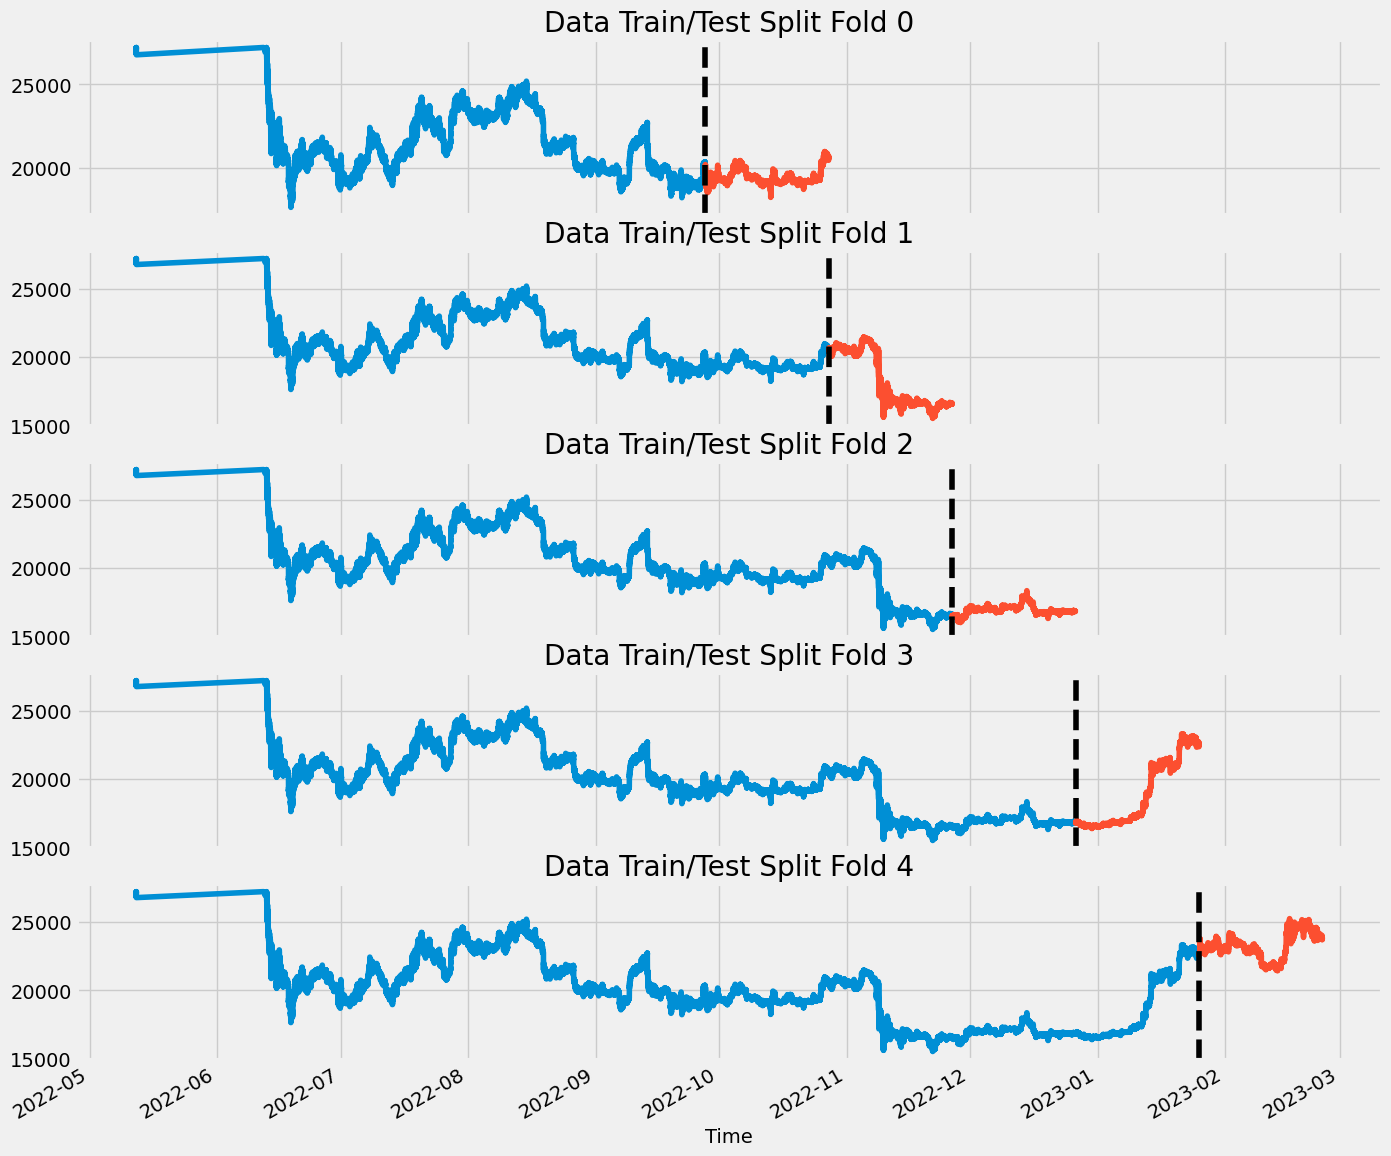

In [36]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True, )
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [187]:
data = Data(df[df.index> pd.to_datetime('2022-05-12 05:10:00')])
data.create_target(task_type='binary_classification')
data.create_features()

In [18]:
df[df['Close'] < 27209.987227].head(7)

,Open,High,Low,Close,Volume
Time,,,,,
2022-05-12 05:10:00,27233.76,27244.98,27110.00,27175.00,428.252329
2022-05-12 05:12:00,27272.76,27272.85,27101.78,27106.94,391.132360
2022-05-12 05:13:00,27106.95,27160.39,27000.00,27021.04,902.231078
2022-05-12 05:14:00,27021.04,27061.95,26927.13,26975.25,449.759181
2022-05-12 05:15:00,26975.25,26979.70,26777.00,26846.82,785.645471
2022-05-12 05:16:00,26846.82,27026.07,26700.00,27025.72,508.539706
2022-05-12 05:22:00,27303.04,27314.35,27051.45,27160.48,357.708180


In [127]:
import json

res_24 = '/home/kenny/algotrading/model_training/feature_exps_results/classification/LightGBM/res-24'
with open(res_24) as f:
    result = json.load(f)
features_24 = result['features']

In [192]:
model = Model(model_name='LightGBM')
result = model.train(data, metric='f1',features=features_24, is_optimized=False)

# optimize_results = '/home/kenny/algotrading/model_training/optimization_results'
# model.optimize(data, optimize_results, features_24)

[1]	training's binary_logloss: 0.689207
[2]	training's binary_logloss: 0.685654
[3]	training's binary_logloss: 0.682361
[4]	training's binary_logloss: 0.679322
[5]	training's binary_logloss: 0.676385
[6]	training's binary_logloss: 0.674063
[7]	training's binary_logloss: 0.671848
[8]	training's binary_logloss: 0.669393
[9]	training's binary_logloss: 0.666868
[10]	training's binary_logloss: 0.664215
[11]	training's binary_logloss: 0.661915
[12]	training's binary_logloss: 0.659416
[13]	training's binary_logloss: 0.657312
[14]	training's binary_logloss: 0.655365
[15]	training's binary_logloss: 0.653264
[16]	training's binary_logloss: 0.651296
[17]	training's binary_logloss: 0.649033
[18]	training's binary_logloss: 0.646957
[19]	training's binary_logloss: 0.644742
[20]	training's binary_logloss: 0.642564
[21]	training's binary_logloss: 0.640274
[22]	training's binary_logloss: 0.638103
[23]	training's binary_logloss: 0.636263
[24]	training's binary_logloss: 0.634449
[25]	training's binary_lo

In [193]:
result

0.844073647871116

In [17]:
model.model_trained

LGBMClassifier()

#### Saving model to onnx format

In [194]:
import onnxmltools
import onnx
from onnxmltools.convert.common.data_types import FloatTensorType, Int64TensorType

def custom_shape_calculator(input_shapes):
    # Calculate the output shape based on the input shape
    output_shape = (input_shapes[0][0], input_shapes[1][1])
    return output_shape

# initial_types = [("float_input", FloatTensorType([None, len(features_24)]))]
# custom_shape_calculators=[custom_shape_calculator]
initial_types = [("input", FloatTensorType([None, len(features_24)]))]
onnx_model = onnxmltools.convert_lightgbm(model.model_trained,initial_types=initial_types, target_opset=9)
onnxmltools.utils.save_model(onnx_model, 'binary_model.onnx')


In [195]:
test = data.df[:20][features_24]
test.head()

,Open,High,Low,Volume,Close,SMA_3,SMA_5,SMA_15,SMA_30,SMA_50,...,close_1,close_2,close_3,close_4,close_5,high_1,high_2,high_3,high_4,high_5
Time,,,,,,,,,,,,,,,,,,,,,
2022-05-12 06:00:00,27128.93,27999.73,26973.28,14726.67283,27114.84,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-12 07:00:00,27114.84,28643.93,26750.00,21433.68996,28193.40,NaN,NaN,NaN,NaN,NaN,...,27114.84,NaN,NaN,NaN,NaN,27999.73,NaN,NaN,NaN,NaN
2022-05-12 08:00:00,28193.40,28323.90,27477.70,10474.28206,28112.80,27807.013333,NaN,NaN,NaN,NaN,...,28193.40,27114.84,NaN,NaN,NaN,28643.93,27999.73,NaN,NaN,NaN
2022-05-12 09:00:00,28112.81,28535.07,27906.64,7016.58804,28061.73,28122.643333,NaN,NaN,NaN,NaN,...,28112.80,28193.40,27114.84,NaN,NaN,28323.90,28643.93,27999.73,NaN,NaN
2022-05-12 10:00:00,28061.74,28929.85,27750.00,7442.23889,28622.32,28265.616667,28021.018,NaN,NaN,NaN,...,28061.73,28112.80,28193.40,27114.84,NaN,28535.07,28323.90,28643.93,27999.73,NaN


#### Inference model from onnx format

In [196]:
import onnxruntime as rt

session = rt.InferenceSession("binary_model.onnx")

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

pred_onnx = session.run( [output_name], {input_name: test.values.astype(np.float32)})[0]
pred_onnx

2023-02-27 07:31:25.443823711 [W:onnxruntime:, execution_frame.cc:835 VerifyOutputSizes] Expected shape from model of {1} does not match actual shape of {20} for output label


array([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
      dtype=int64)

#### Check that predictions are equals

In [197]:
pred = model.model_trained.predict(test)
test["predicted"] = pred
test["onnx_predicted"] = pred_onnx
test

,Open,High,Low,Volume,Close,SMA_3,SMA_5,SMA_15,SMA_30,SMA_50,...,close_3,close_4,close_5,high_1,high_2,high_3,high_4,high_5,predicted,onnx_predicted
Time,,,,,,,,,,,,,,,,,,,,,
2022-05-12 06:00:00,27128.93,27999.73,26973.28,14726.67283,27114.84,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2022-05-12 07:00:00,27114.84,28643.93,26750.00,21433.68996,28193.40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27999.73,NaN,NaN,NaN,NaN,0,0
2022-05-12 08:00:00,28193.40,28323.90,27477.70,10474.28206,28112.80,27807.013333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,28643.93,27999.73,NaN,NaN,NaN,0,0
2022-05-12 09:00:00,28112.81,28535.07,27906.64,7016.58804,28061.73,28122.643333,NaN,NaN,NaN,NaN,...,27114.84,NaN,NaN,28323.90,28643.93,27999.73,NaN,NaN,1,1
2022-05-12 10:00:00,28061.74,28929.85,27750.00,7442.23889,28622.32,28265.616667,28021.018,NaN,NaN,NaN,...,28193.40,27114.84,NaN,28535.07,28323.90,28643.93,27999.73,NaN,0,0
2022-05-12 11:00:00,28622.31,29294.00,28325.00,7086.66545,28472.98,28385.676667,28292.646,NaN,NaN,NaN,...,28112.80,28193.40,27114.84,28929.85,28535.07,28323.90,28643.93,27999.73,1,1
2022-05-12 12:00:00,28472.98,28777.28,27955.00,6607.15895,28506.30,28533.866667,28355.226,NaN,NaN,NaN,...,28061.73,28112.80,28193.40,29294.00,28929.85,28535.07,28323.90,28643.93,0,0
2022-05-12 13:00:00,28506.30,28891.00,27902.95,8011.80828,28208.31,28395.863333,28374.328,NaN,NaN,NaN,...,28622.32,28061.73,28112.80,28777.28,29294.00,28929.85,28535.07,28323.90,1,1
2022-05-12 14:00:00,28208.32,29672.35,27970.82,10217.30276,29580.94,28765.183333,28678.170,NaN,NaN,NaN,...,28472.98,28622.32,28061.73,28891.00,28777.28,29294.00,28929.85,28535.07,0,0


In [ ]:
# session = rt.InferenceSession('model.onnx', sess_options={'shape_inference_mode': 'ONNX_USE_STATIC_SHAPE'})
# outputs = session.run(inputs={'input_tensor': input_tensor},
#                       outputs=['output_tensor'])
# input_name = session.get_inputs()[0].name

# session = onnxruntime.InferenceSession(model_path, sess_options={'shape_inference_mode': 'ONNX_USE_STATIC_SHAPE'}, providers=providers)
# outputs = session.run(input_feed, output_feed, enable_profiling=enable_profiling, execution_mode=execution_mode)


# pred_onnx = session.run({input_name: test.values.astype(np.float32)}, outputs=['output_tensor'])[0]
# reshaped_tensor = reshape(outputs['output_tensor'], (10,))